# Cell level classifiers using pre-trained DINO features

In [44]:
from torch.utils.data import DataLoader
import torchvision.transforms as T 
import torch
from tqdm import tqdm
import numpy as np


def extract_dino_patch_features(imgs, transform=None, device='cuda:7'):
  model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device)
  model.eval()
  z = np.zeros((len(imgs), 384))
  i = 0
  loader = DataLoader(imgs, batch_size=128, shuffle=False)
  # for batch in tqdm(loader):
  for batch in tqdm(loader):
    batch = batch.to(device).repeat(1, 3, 1, 1)
    if transform is not None:
      batch = transform(batch)
    with torch.no_grad():
      z[i:i+len(batch)] = model(batch).cpu().numpy()
    i += len(batch)
  return z


# DINO needs python 3.10 but the rest of the code is for python 3.9
# so we extract and save features first

save_dir = f'/ewsc/hschluet/pbmc5/bundled_data/'
plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
for plate in plates:
  imgs = torch.load(f'{save_dir}plate_{plate}_imgs.pt').unsqueeze(1)
  dino_zs = extract_dino_patch_features(T.CenterCrop(28)(imgs))
  torch.save(dino_zs, f'{save_dir}plate_{plate}_dino_feats.pt')

Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 577/577 [00:03<00:00, 171.24it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1126/1126 [00:06<00:00, 171.74it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 272/272 [00:01<00:00, 168.72it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1289/1289 [00:07<00:00, 169.87it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 912/912 [00:05<00:00, 173.40it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1135/1135 [00:06<00:00, 170.15it/s]
Using cache found in /local_home/hschluet/.cache/torch/hub/facebookresearch_dinov2_main
100%|██████████| 1078/1078 [00:06<00:00, 172.99it/s]
Using cache found i

In [11]:
import importlib 
import data, util, models, training

importlib.reload(data)
importlib.reload(util)
importlib.reload(models)
importlib.reload(training)

<module 'training' from '/home/unix/hschluet/projects/pt-pbmc/training.py'>

In [30]:
from data import PlateDataset
from util import torch_random_choice
from models import MultiFeatClassifier, FeatClassifier
from training import train_model
from torch.utils.data import DataLoader
import torchvision.transforms as T 

import torch
import numpy as np
import pandas as pd
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import torchvision.transforms as T 
import seaborn as sns


device = 'cuda:6'

In [13]:
data = PlateDataset([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], load_dino=True)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:29<00:00,  1.86s/it]


In [14]:
data.info

,plate,well,series,cell,patient,time,qc,group
0,1,A02,0,25,H01,0,True,healthy
1,1,A02,0,30,H01,0,True,healthy
2,1,A02,0,37,H01,0,True,healthy
3,1,A02,0,43,H01,0,True,healthy
4,1,A02,0,44,H01,0,True,healthy
...,...,...,...,...,...,...,...,...
1093961,16,H12,9,565,H15,0,True,healthy
1093962,16,H12,9,569,H15,0,True,healthy
1093963,16,H12,9,570,H15,0,True,healthy
1093964,16,H12,9,572,H15,0,True,healthy


In [15]:
data.imgs.shape

torch.Size([1093966, 1, 32, 32])

In [16]:
data.dino_zs.shape

(1093966, 384)

## Classification between largest cancer types and healthy

Include healthy in objective as it is shared across plates and cancer types classification could cheat using plate effect.

In [17]:
data.info.groupby(['plate', 'group'])['cell'].count()

plate  group                   
1      CNS-Glioma                   34596
       healthy                       7996
2      CNS-Glioma                   50189
       healthy                       4532
3      H&N cancer                   15259
       healthy                       1717
4      H&N cancer                   88198
       healthy                       8861
5      H&N cancer                   15530
       healthy                       1661
6      H&N cancer                   64118
       healthy                       4591
7      CNS-Meningioma               88192
       healthy                      13659
8      CNS-Meningioma               32397
       Lymphoma                     46938
       healthy                       9107
9      CNS-Meningioma               18910
       healthy                       4418
10     Chordoma/Chondrosarcoma      70034
       healthy                       5830
11     Chordoma/Chondrosarcoma      39004
       healthy                       2445
12

In [18]:
data.info.groupby(['plate', 'group'])['patient'].unique()

plate  group                   
1      CNS-Glioma                        [P51, P57, P132, P46, P47, P108, P68, P150]
       healthy                                             [H01, H04, H02, H05, H03]
2      CNS-Glioma                   [P116, P15, P124, P52, P22, P29, P16, P104, P84]
       healthy                                                  [H05, H04, H06, H07]
3      H&N cancer                   [P115, P72, P50, P67, P100, P77, P56, P125, P41]
       healthy                                                  [H06, H30, H23, H07]
4      H&N cancer                  [P129, P137, P107, P114, P149, P79, P120, P145...
       healthy                                                  [H40, H10, H30, H23]
5      H&N cancer                  [P148, P78, P63, P24, P18, P135, P12, P142, P161]
       healthy                                                  [H40, H31, H10, H39]
6      H&N cancer                  [P94, P166, P147, P14, P154, P55, P44, P98, P1...
       healthy                   

In [19]:
use_plates = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
cdf = data.info[data.info['group'].isin(use_groups) & data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H06', 'H07', 'H09', 'H10', 'H16', 'H19', 'H20', 'H22', 'H23',
       'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36', 'H37', 'H39',
       'H40', 'H43', 'H47', 'H49', 'P102', 'P105', 'P106', 'P107', 'P110',
       'P112', 'P114', 'P115', 'P118', 'P119', 'P120', 'P125', 'P126',
       'P128', 'P129', 'P130', 'P131', 'P134', 'P135', 'P137', 'P138',
       'P14', 'P142', 'P143', 'P144', 'P145', 'P147', 'P148', 'P149',
       'P152', 'P154', 'P155', 'P160', 'P161', 'P162', 'P163', 'P165',
       'P166', 'P18', 'P21', 'P23', 'P24', 'P25', 'P27', 'P33', 'P37',
       'P38', 'P42', 'P43', 'P44', 'P48', 'P55', 'P59', 'P62', 'P63',
       'P67', 'P69', 'P70', 'P72', 'P76', 'P78', 'P79', 'P83', 'P86',
       'P90', 'P92', 'P94', 'P98', 'P99'], dtype=object)

In [20]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [21]:
use_plates = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
use_groups = ['healthy', 'H&N cancer', 'CNS-Meningioma', 'Chordoma/Chondrosarcoma'] 
short_groups = {'healthy' : 'H', 'H&N cancer' : 'H&N', 'CNS-Meningioma' : 'M', 
                'Chordoma/Chondrosarcoma' : 'C/C'}  
group_map = {'healthy' : 0, 'H&N cancer' : 1, 'CNS-Meningioma' : 2, 'Chordoma/Chondrosarcoma' : 3} 

def group_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = torch.from_numpy(data.dino_zs[use_idx]).to(device)
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['group'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)]).loc[use_groups]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
  pat_min = pat_groups.map(len).min()

  while True:
    labels = []
    xs = []
    for label in use_groups:
      pat_sub = np.random.choice(pat_groups[label], size=pat_min, replace=False)
      for pat in pat_sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.extend([group_map[label]] * bag_size)

    labels = torch.tensor(labels).to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * len(use_groups) * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_group_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = torch.from_numpy(data.dino_zs[use_idx]).to(device)
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_groups = data.info.groupby(['patient'])['group'].max()
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    xs = use_data[idx]
    label = pat_groups[pat]
    yield xs.float(), use_imgs[idx].float(), torch.tensor(group_map[label]).to(device), pat, label

In [26]:
def eval_model(name, loader, classes=5):
    model = MultiFeatClassifier(classes=classes, input_dim=384)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (z, bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, _ = model(z.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

### Big model

iter: 399999; train loss: 0.86513090; train error: 0.34000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:15<00:00, 502.74it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_groups_by_cell_pretrained_dino_model.pt


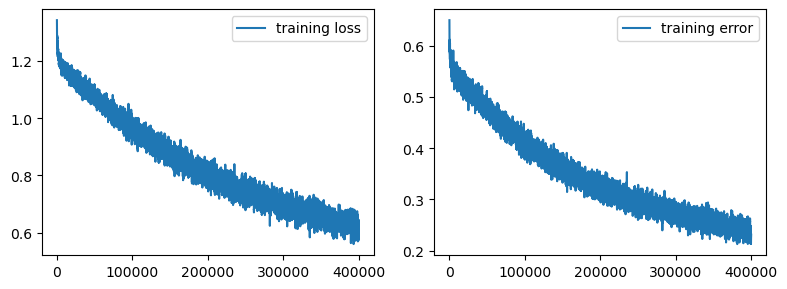

In [24]:
name = '3_12_t01_healthy_groups_by_cell_pretrained_dino'
train_loader = group_bagloader()
model = MultiFeatClassifier(classes=len(use_groups), input_dim=384)
df = train_model(model, bag_loader=train_loader, num_iter=400_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341)

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [27]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('3_12_t01_healthy_groups_by_cell_pretrained_dino', test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  3.40it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,0,0,H06,healthy,3
2,0,1,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,0,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,2,6,P21,Chordoma/Chondrosarcoma,12
10896,3,3,6,P21,Chordoma/Chondrosarcoma,12
10897,3,1,6,P21,Chordoma/Chondrosarcoma,12
10898,3,1,6,P21,Chordoma/Chondrosarcoma,12


In [28]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,90
1,3,H06,H,H&N,7
2,3,H06,H,C/C,3
3,3,H07,H,H,99
4,3,H07,H,H&N,1
...,...,...,...,...,...
380,12,P155,C/C,M,17
381,12,P21,C/C,C/C,64
382,12,P21,C/C,M,19
383,12,P21,C/C,H&N,11


/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/194

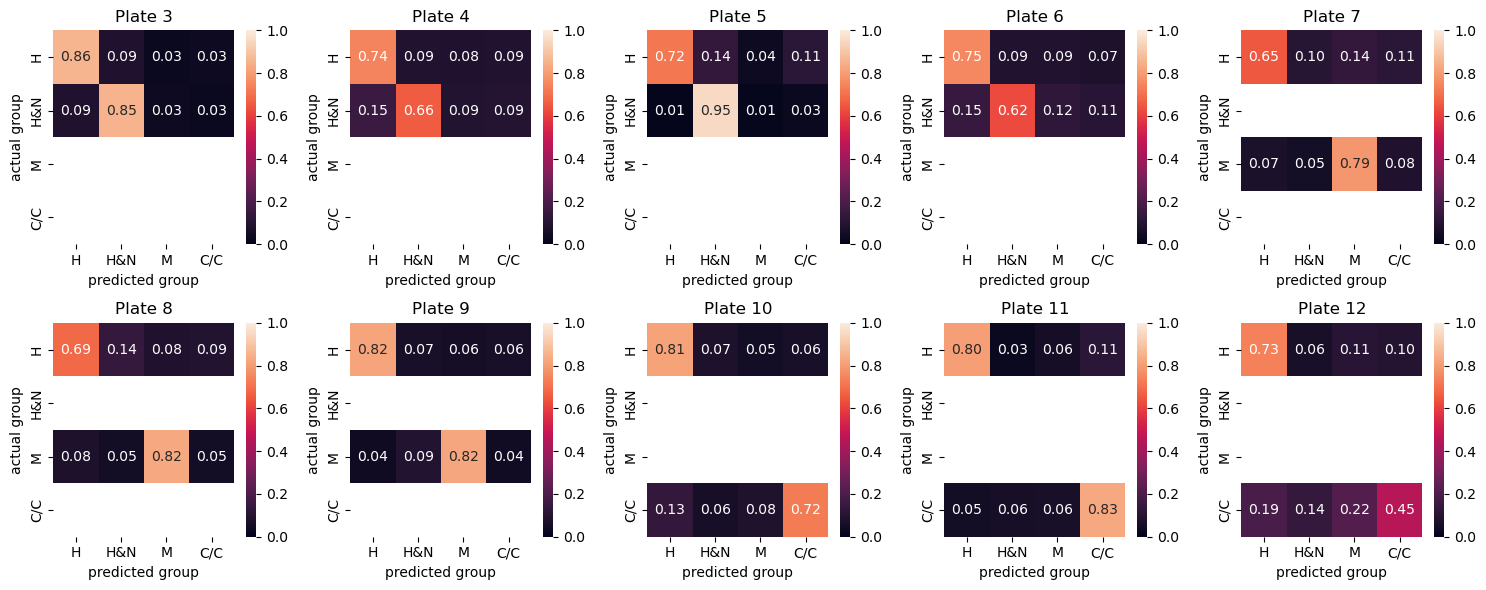

In [31]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_249867/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


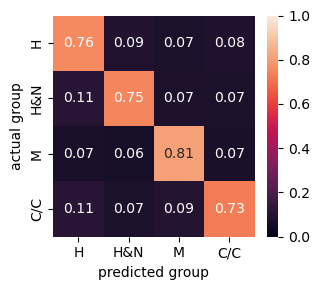

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

iter: 399999; train loss: 0.54219735; train error: 0.20000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:08<00:00, 507.33it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_3_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.60250503; train error: 0.20000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:20<00:00, 499.44it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_4_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.85834730; train error: 0.31999999: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:01<00:00, 512.08it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_5_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.43026108; train error: 0.12000000: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:49<00:00, 519.48it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_6_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.41047823; train error: 0.16000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:55<00:00, 515.67it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_7_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.69571632; train error: 0.28000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:54<00:00, 516.22it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_8_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.39379570; train error: 0.10000002: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:05<00:00, 509.35it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_9_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.41666058; train error: 0.16000003: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [12:55<00:00, 515.92it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_10_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.68844569; train error: 0.24000001: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:18<00:00, 500.88it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_11_by_cell_pretrained_dino_model.pt


iter: 399999; train loss: 0.43774548; train error: 0.14000005: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 400000/400000 [13:07<00:00, 507.64it/s]


/ewsc/hschluet/models/pbmc5/rerun//3_12_t01_healthy_cancer_without_plate_12_by_cell_pretrained_dino_model.pt


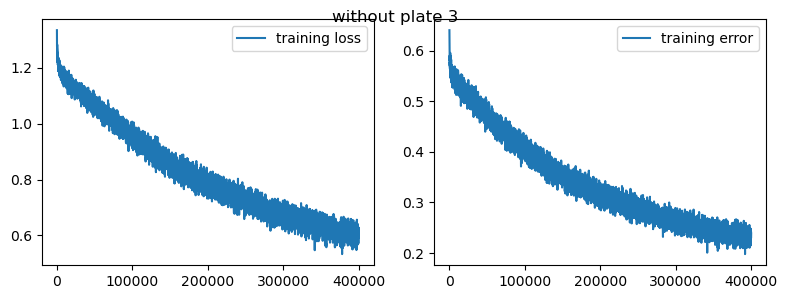

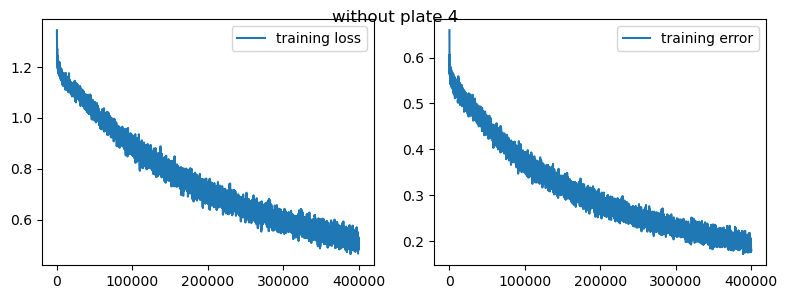

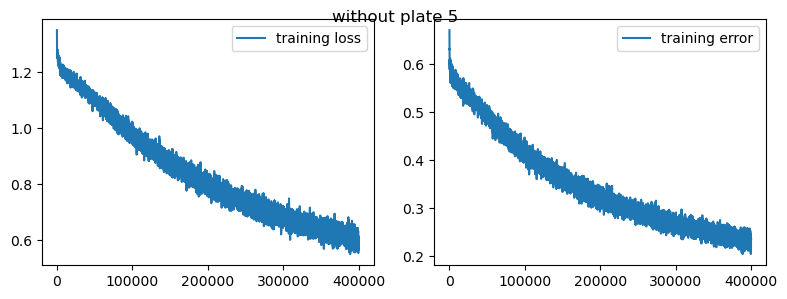

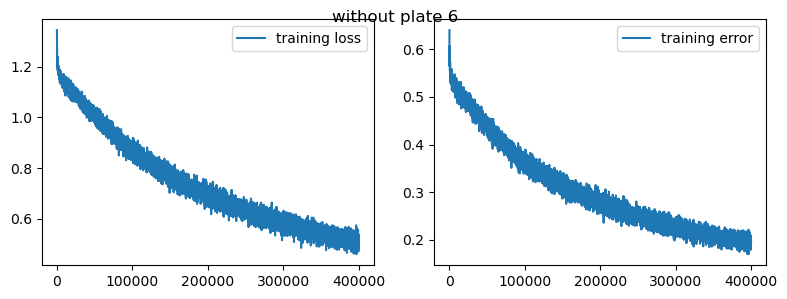

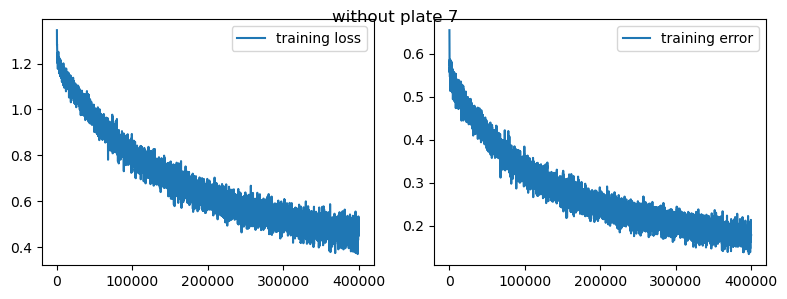

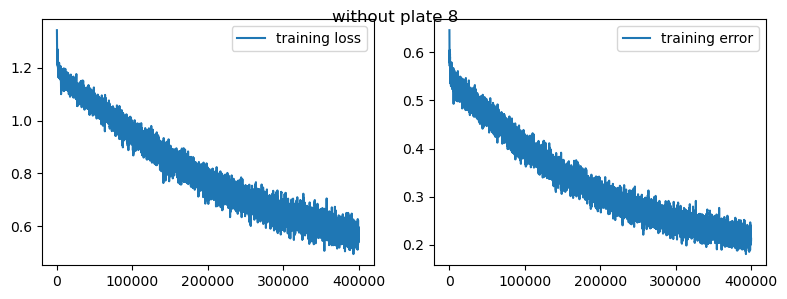

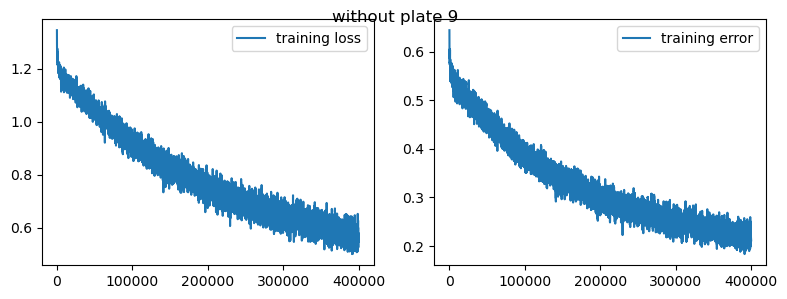

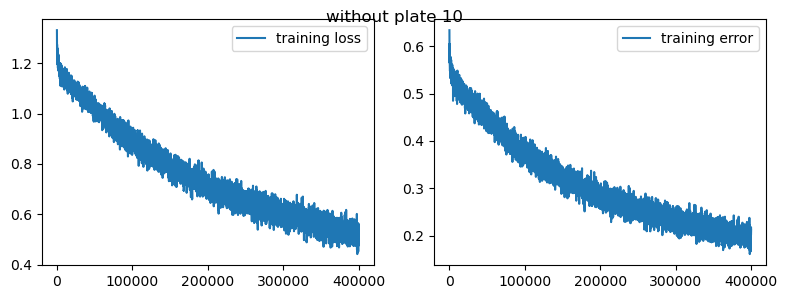

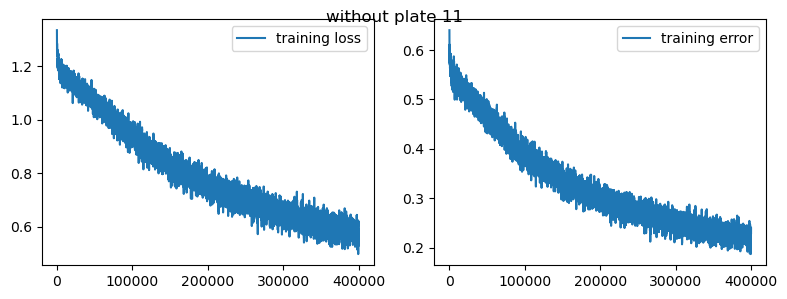

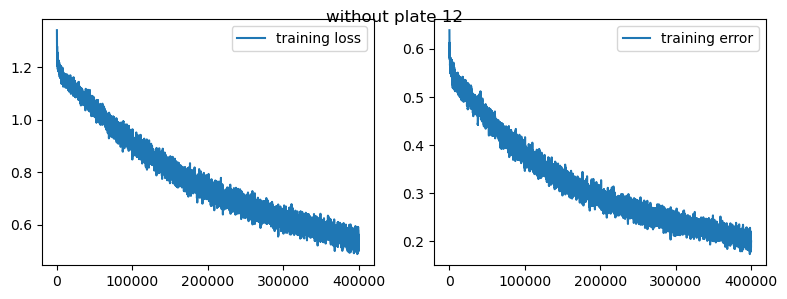

In [33]:
for plate in use_plates:
    name = f'3_12_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_dino'
    train_loader = group_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = MultiFeatClassifier(classes=len(use_groups), input_dim=384)
    df = train_model(model, bag_loader=train_loader, num_iter=400_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341)

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [34]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'3_12_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_dino', 
                        test_group_bagloader(use_plates=[plate]), classes=len(use_groups))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.03it/s]


,lab,pred,i,pat,group,plate
0,0,0,0,H06,healthy,3
1,0,0,0,H06,healthy,3
2,0,1,0,H06,healthy,3
3,0,0,0,H06,healthy,3
4,0,1,0,H06,healthy,3
...,...,...,...,...,...,...
10895,3,3,6,P21,Chordoma/Chondrosarcoma,12
10896,3,3,6,P21,Chordoma/Chondrosarcoma,12
10897,3,0,6,P21,Chordoma/Chondrosarcoma,12
10898,3,1,6,P21,Chordoma/Chondrosarcoma,12


In [35]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df['pred'] = pd.Categorical(values=pat_df['pred'].map(lambda x: use_groups[x]).replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df['group'] = pd.Categorical(values=pat_df['group'].replace(short_groups), categories=['H', 'H&N', 'M', 'C/C'])
pat_df

,plate,pat,group,pred,counts
0,3,H06,H,H,58
1,3,H06,H,H&N,21
2,3,H06,H,C/C,13
3,3,H06,H,M,8
4,3,H07,H,H,55
...,...,...,...,...,...
431,12,P155,C/C,C/C,12
432,12,P21,C/C,M,38
433,12,P21,C/C,C/C,28
434,12,P21,C/C,H&N,27


/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/1949248397.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df[pat_df['plate'] == plate].groupby(
/tmp/ipykernel_249867/194

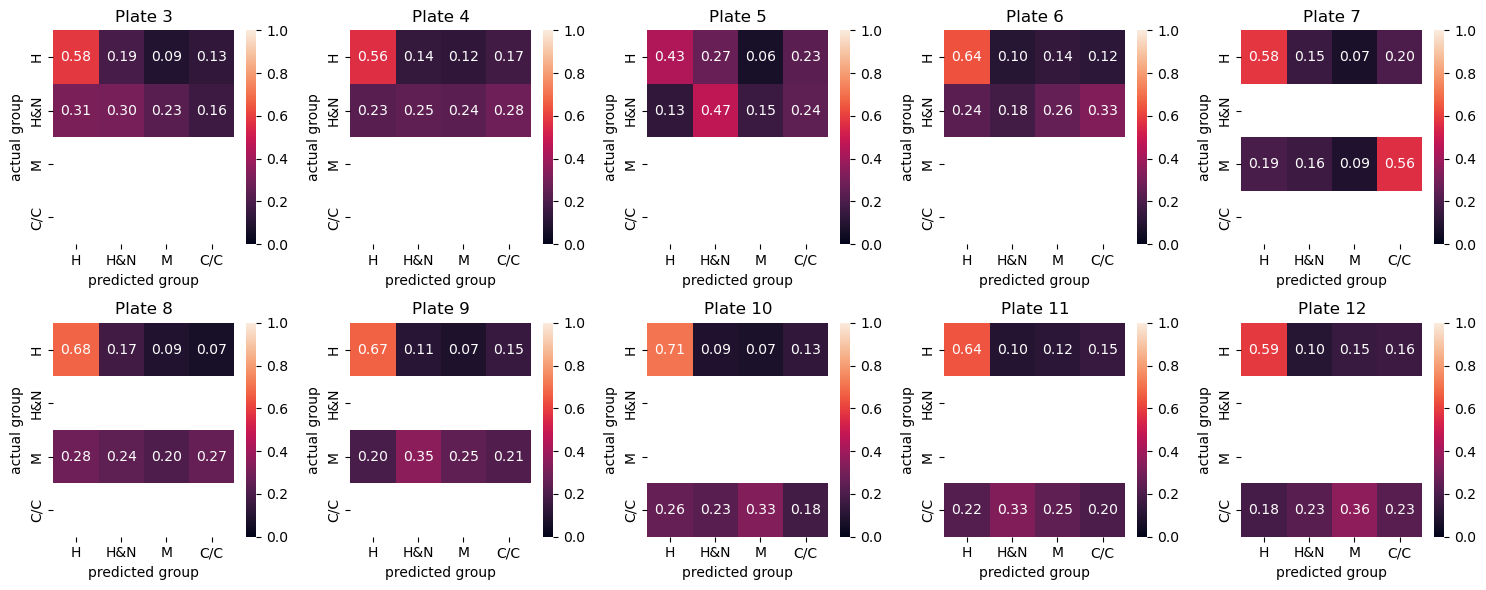

In [36]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

/tmp/ipykernel_249867/1759129104.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mat = pat_df.groupby(


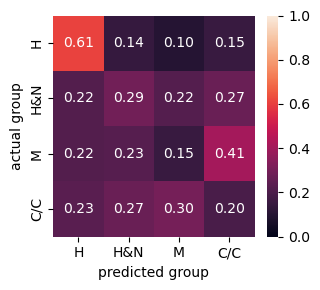

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

## Classification cancer T1 and healthy

In [38]:
use_plates = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
cdf = data.info[data.info['plate'].isin(use_plates)].groupby(
    ['patient', 'time'])['cell'].count().reset_index()
cdf = cdf[(cdf['cell'] > 100)]

p01s = cdf[(cdf['time'] == 1) | (cdf['time'] == 0)]['patient'].unique()
p01s

array(['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H09', 'H10',
       'H13', 'H15', 'H16', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23',
       'H24', 'H25', 'H26', 'H29', 'H30', 'H31', 'H32', 'H33', 'H36',
       'H37', 'H39', 'H40', 'H43', 'H45', 'H47', 'H48', 'H49', 'P102',
       'P103', 'P104', 'P105', 'P106', 'P107', 'P109', 'P11', 'P110',
       'P111', 'P112', 'P113', 'P114', 'P115', 'P116', 'P117', 'P118',
       'P119', 'P120', 'P121', 'P123', 'P124', 'P125', 'P126', 'P127',
       'P128', 'P129', 'P13', 'P130', 'P131', 'P132', 'P134', 'P135',
       'P136', 'P137', 'P138', 'P139', 'P14', 'P140', 'P142', 'P143',
       'P144', 'P145', 'P146', 'P147', 'P148', 'P149', 'P15', 'P150',
       'P151', 'P152', 'P154', 'P155', 'P156', 'P158', 'P159', 'P16',
       'P160', 'P161', 'P162', 'P163', 'P164', 'P165', 'P166', 'P167',
       'P17', 'P18', 'P19', 'P20', 'P21', 'P22', 'P23', 'P24', 'P25',
       'P27', 'P28', 'P29', 'P30', 'P32', 'P33', 'P34', 'P35', 'P37',
       'P38', 'P

In [39]:
data.info.groupby(['group'])['patient'].unique().map(len)

group
CNS-Ependymoma               7
CNS-Glioma                  17
CNS-Medulloblastoma          7
CNS-Meningioma              19
CNS-other                   12
Chordoma/Chondrosarcoma     21
H&N cancer                  37
Lymphoma                     7
Sarcoma-Ewing                8
Sarcoma-Neuroblastoma        2
Sarcoma-Rhabdomyosarcoma     4
Sarcoma-other                3
healthy                     35
Name: patient, dtype: int64

In [43]:
use_plates = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])


def healthy_vs_cancer_bagloader(bag_size=50, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = torch.from_numpy(data.dino_zs[use_idx]).to(device)
  
  plate_pats = np.concatenate(data.info.groupby(['plate'])['patient'].unique().loc[use_plates].values)
  use_patients = use_patients[np.isin(use_patients, plate_pats)]
  
  pat_groups = data.info.groupby(['time'])['patient'].unique().map(lambda x: x[np.isin(x, use_patients)])
  pat_healthy = pat_groups[0]
  pat_cancer = pat_groups[1]
  pat_lut = {}
  for pat in use_patients:
    pat_lut[pat] = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)

  pat_min = min(len(pat_healthy), len(pat_cancer))
  while True:
    xs = []
    labels = []
    for lab, pats in zip([0, 1], [pat_cancer, pat_healthy]):
      sub = np.random.choice(pats, size=pat_min, replace=False)
      for pat in sub:
        xs.append(use_data[torch_random_choice(pat_lut[pat], size=bag_size)])
        labels.append(lab * torch.ones(bag_size))
    
    labels = torch.cat(labels).float().to(device) 
    xs = torch.cat(xs).float()
    # shuffle indices
    rand_idx = torch.randperm(len(xs))
    for left in range(0, bag_size * 2 * pat_min, bag_size):
      yield xs[rand_idx[left:left+bag_size]], labels[rand_idx[left:left+bag_size]]


def test_healthy_vs_cancer_bagloader(bag_size=100, use_patients=p01s, use_times=[0, 1], use_plates=use_plates, device=device, transform=T.CenterCrop(28)):
  use_idx = torch.argwhere(torch.from_numpy((data.info['plate'].isin(use_plates) & data.info['time'].isin(use_times)).values)).flatten()
  use_data = torch.from_numpy(data.dino_zs[use_idx]).to(device)
  use_imgs = transform(data.imgs[use_idx].to(device))
  
  pat_plates = data.info.groupby(['patient'])['plate'].unique()
  for pat in use_patients:
    if not np.isin(pat_plates[pat], use_plates).any():
      continue
    pat_idx = torch.argwhere(torch.from_numpy((data.info.loc[use_idx]['patient'] == pat).values)).flatten().to(device)
    idx = torch_random_choice(pat_idx, size=bag_size)
    xs = use_data[idx]
    label = 1 if pat[0] == 'H' else 0
    yield xs.float(), use_imgs[idx].float(), torch.tensor(label).to(device), pat, 'healthy' if pat[0] == 'H' else 'cancer'

In [48]:
def eval_model(name, loader):
    model = FeatClassifier(input_dim=384)
    model = model.to(device)
    model.load_state_dict(torch.load(f'/ewsc/hschluet/models/pbmc5/rerun/{name}_model.pt', weights_only=True, map_location=device))
    model.eval()

    np.random.seed(1232412)
    torch.manual_seed(124514)
    torch.cuda.manual_seed_all(13513)

    bag_labs = []
    bag_pred = []
    bag_ids = []
    bag_zs = []
    bag_pats = []
    bag_groups = []
    bags = []
    for i, (z, bag, lab, pat, group) in enumerate(loader):
        with torch.no_grad():
            _, pred, _ = model(z.to(device))
        bag_ids.extend([i] * 100)
        bag_pats.extend([pat] * 100)
        bag_groups.extend([group] * 100)
        bag_labs.extend([lab.item()] * 100)
        bag_pred.extend(pred.cpu().numpy())
        bag_zs.extend(z.cpu().numpy())
        bags.extend(bag.cpu().numpy())

    df = pd.DataFrame()
    df['lab'] = bag_labs
    df['pred'] = bag_pred
    df['i'] = bag_ids
    df['pat'] = bag_pats
    df['group'] = bag_groups
    return df, bag_zs, bags

In [49]:
xs, labs = next(healthy_vs_cancer_bagloader())
labs

tensor([1., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 0.],
       device='cuda:6')

In [50]:
xs

tensor([[-0.6662,  1.2919,  1.3834,  ..., -1.2036, -1.3173,  4.6162],
        [-0.1478,  1.5329,  1.1201,  ..., -0.5893,  0.2538,  5.3746],
        [ 0.8075,  1.3198,  1.2900,  ..., -0.8516,  0.9330,  3.5477],
        ...,
        [ 1.4476,  0.9568,  1.1036,  ..., -0.8645,  1.0405,  3.5752],
        [ 0.3842,  2.4861,  0.3916,  ...,  1.1236,  1.7326,  4.1988],
        [-1.0902,  1.4591,  1.8409,  ...,  0.6462, -0.7196,  3.8339]],
       device='cuda:6')

### Big model

  0%|                                                                                                                                                                                      | 0/100000 [00:00<?, ?it/s]

iter: 99999; train loss: 0.48947784; train error: 0.31999999: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:37<00:00, 459.92it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_by_cell_pretrained_dino_model.pt


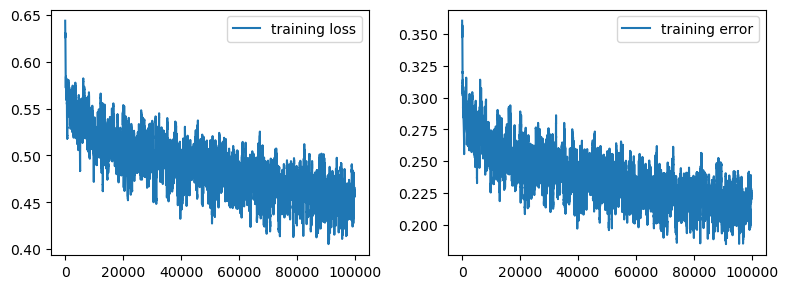

In [51]:
name = '1_16_t01_healthy_cancer_by_cell_pretrained_dino'
train_loader = healthy_vs_cancer_bagloader()
model = FeatClassifier(input_dim=384)
df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                 save_model=True, seed=12341)

w = 100
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
ax1.legend()
ax2.legend()
fig.tight_layout()
fig.show()

In [52]:
dfs = []
bag_zs = []
imgs = []
for plate in tqdm(use_plates):
  df, zs, b = eval_model('1_16_t01_healthy_cancer_by_cell_pretrained_dino', 
                         test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)
  bag_zs.append(zs)
  imgs.append(b)

res_df = pd.concat(dfs, ignore_index=True)
bag_zs = np.concatenate(bag_zs)
imgs = np.concatenate(imgs)
res_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:03<00:00,  5.33it/s]


,lab,pred,i,pat,group,plate
0,1,1.0,0,H01,healthy,1
1,1,1.0,0,H01,healthy,1
2,1,0.0,0,H01,healthy,1
3,1,1.0,0,H01,healthy,1
4,1,1.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,0.0,11,P74,cancer,16
20197,0,0.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [53]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1.0,80
1,1,H01,healthy,0.0,20
2,1,H02,healthy,1.0,90
3,1,H02,healthy,0.0,10
4,1,H03,healthy,1.0,96
...,...,...,...,...,...
398,16,P45,cancer,1.0,27
399,16,P61,cancer,0.0,75
400,16,P61,cancer,1.0,25
401,16,P74,cancer,0.0,81


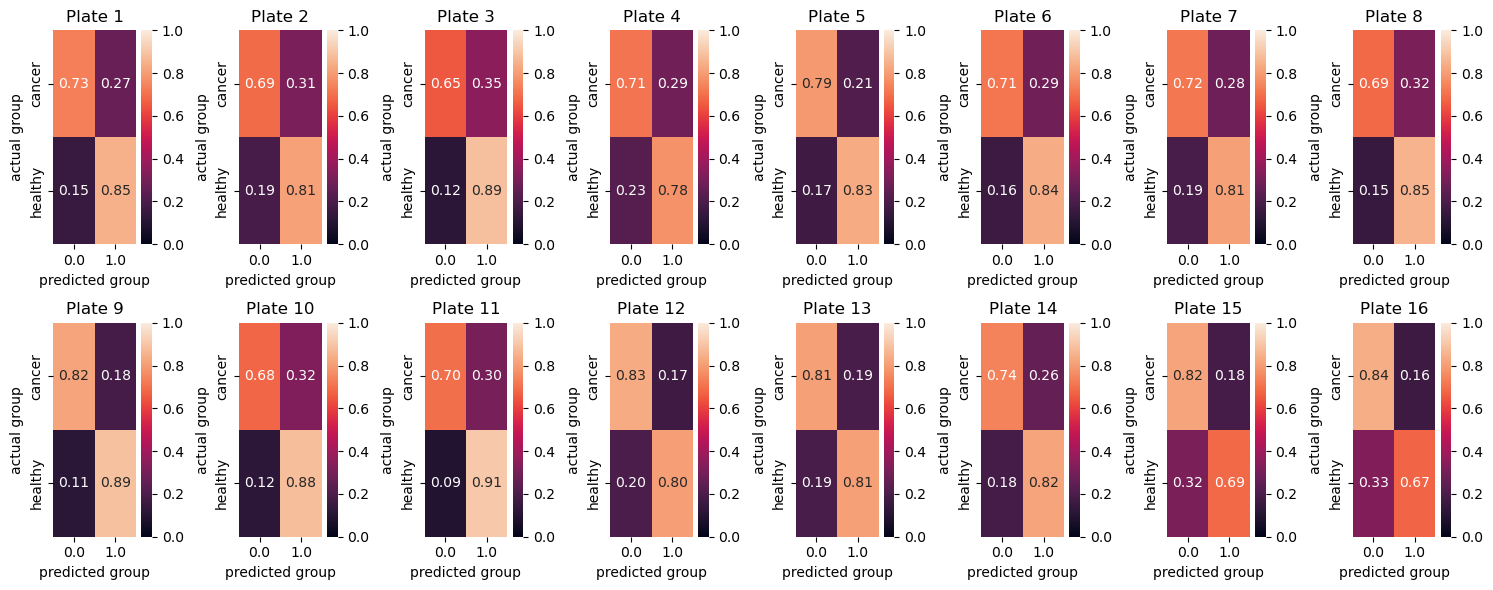

In [54]:
fig, axs = plt.subplots(2, 8, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

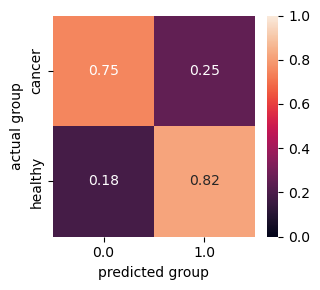

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

### Leave out one plate

iter: 99999; train loss: 0.31663972; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:29<00:00, 477.34it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_1_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.43102795; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:31<00:00, 472.71it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_2_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.35013077; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:35<00:00, 464.00it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_3_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.40962234; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:38<00:00, 458.32it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_4_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.33621123; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:25<00:00, 486.22it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_5_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.40332189; train error: 0.16000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:29<00:00, 478.44it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_6_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.43885469; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:16<00:00, 508.38it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_7_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.40261737; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:21<00:00, 496.81it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_8_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.36963722; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:16<00:00, 509.06it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_9_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.42393324; train error: 0.14000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:27<00:00, 481.05it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_10_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.41148329; train error: 0.18000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:18<00:00, 503.43it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_11_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.38240260; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:14<00:00, 513.40it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_12_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.52557749; train error: 0.28000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:21<00:00, 496.78it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_13_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.45761344; train error: 0.20000005: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:24<00:00, 489.53it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_14_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.42527375; train error: 0.24000001: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:20<00:00, 498.57it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_15_by_cell_pretrained_dino_model.pt


iter: 99999; train loss: 0.49160275; train error: 0.22000003: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [03:21<00:00, 495.18it/s]


/ewsc/hschluet/models/pbmc5/rerun//1_16_t01_healthy_cancer_without_plate_16_by_cell_pretrained_dino_model.pt


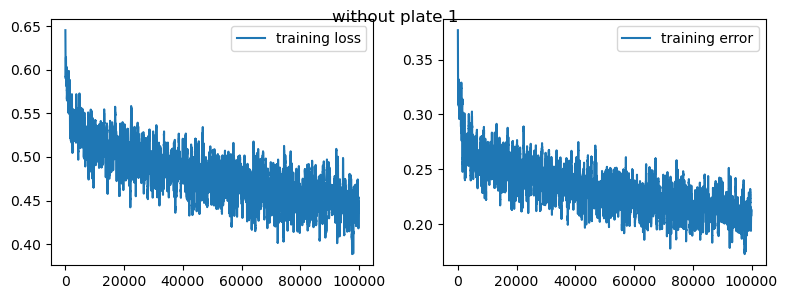

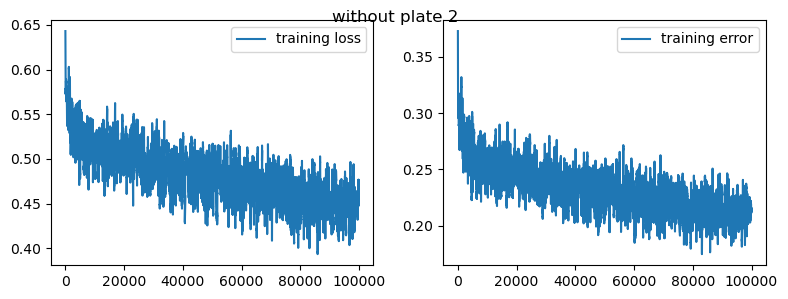

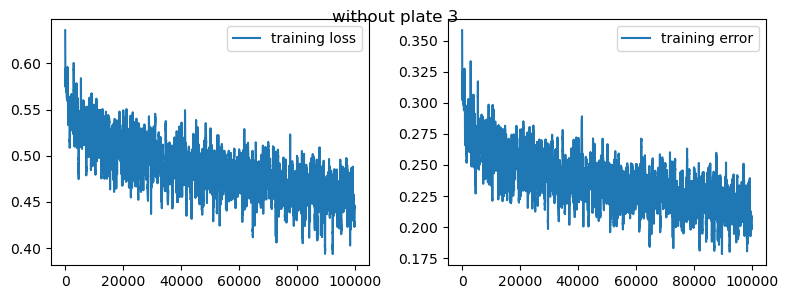

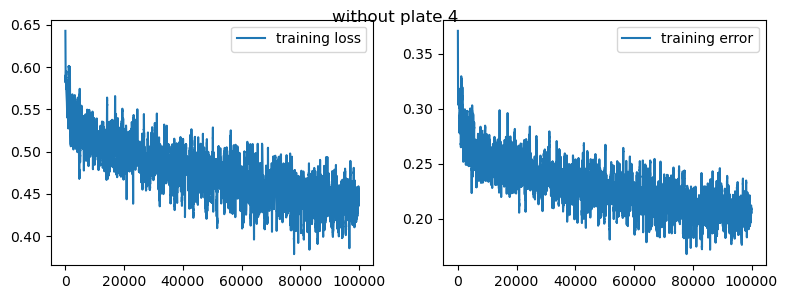

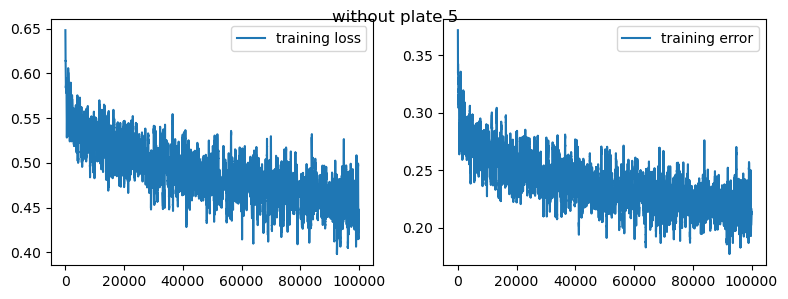

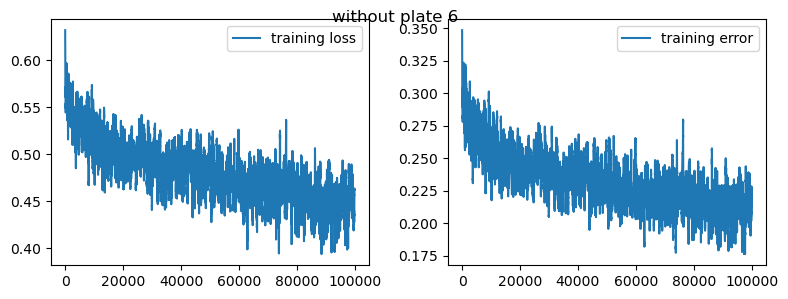

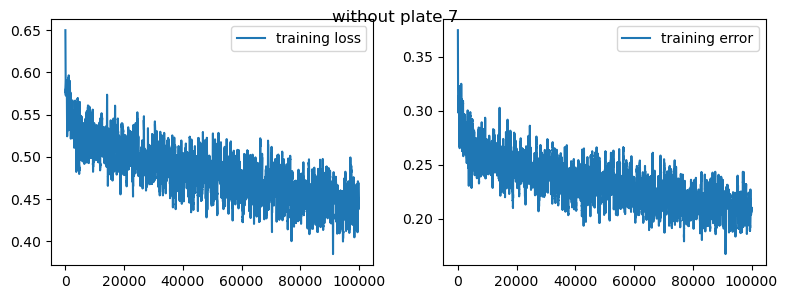

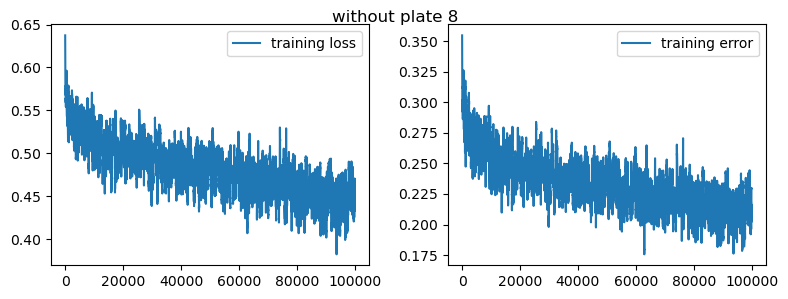

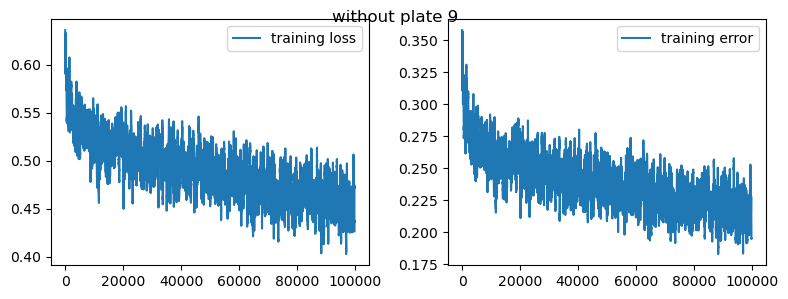

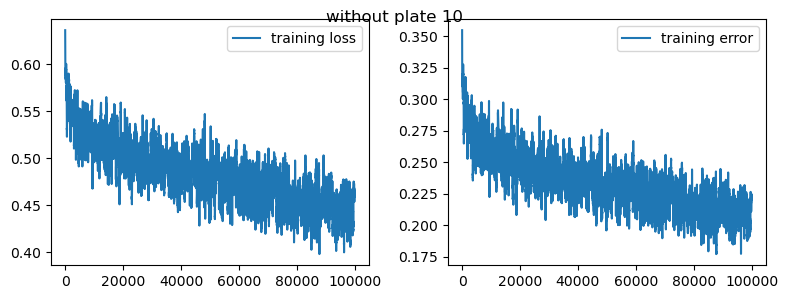

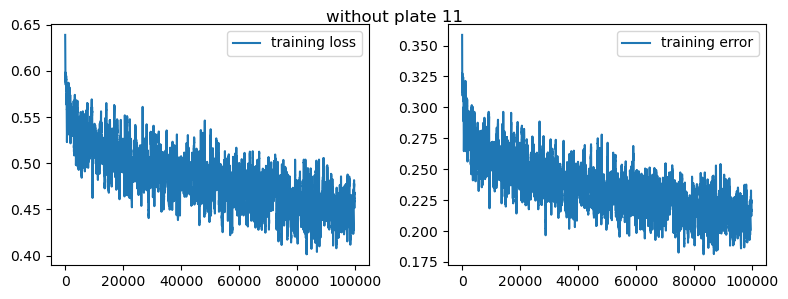

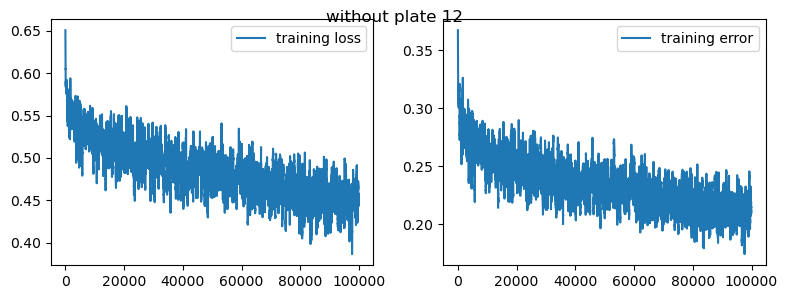

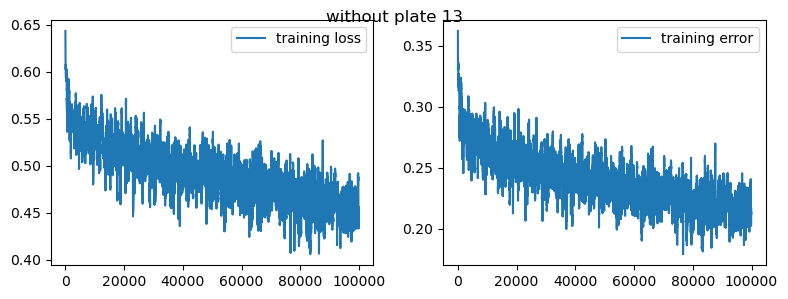

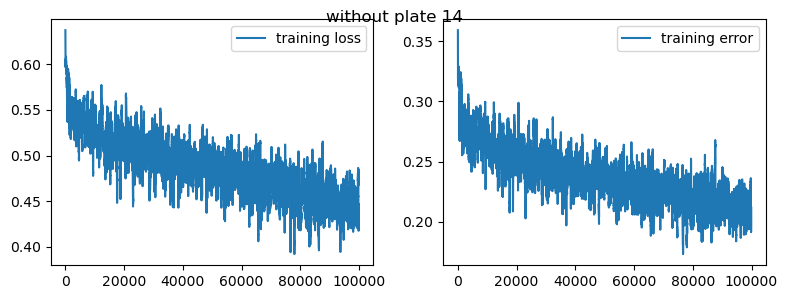

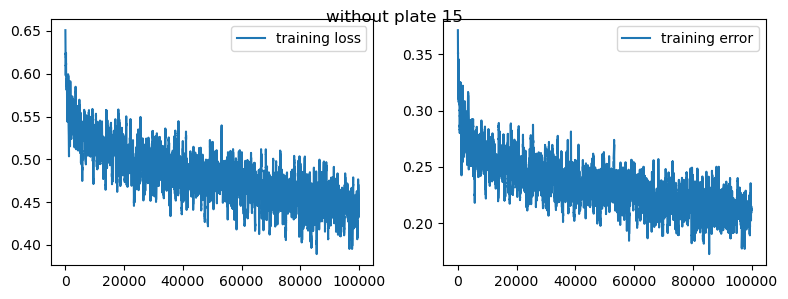

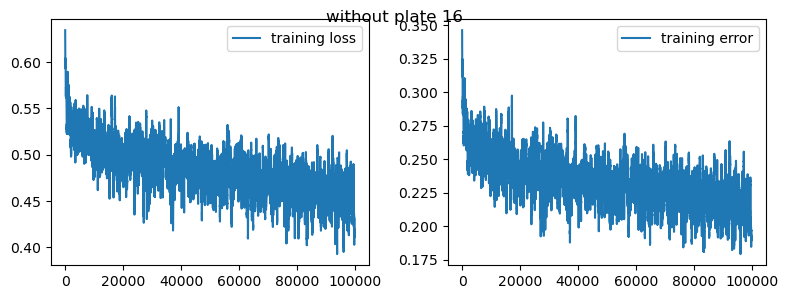

In [56]:
for plate in use_plates:
    name = f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_dino'
    train_loader = healthy_vs_cancer_bagloader(use_plates=use_plates[use_plates != plate].copy())
    model = FeatClassifier(input_dim=384)
    df = train_model(model, bag_loader=train_loader, num_iter=100_000, lr=0.0001, device=device, fname=name, plot=False, 
                     save_model=True, seed=12341)

    w = 100
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
    ax1.plot(np.convolve(df['train loss'], np.ones(w), 'valid') / w, label='training loss')
    ax2.plot(np.convolve(df['train error'], np.ones(w), 'valid') / w, label='training error')
    ax1.legend()
    ax2.legend()
    fig.tight_layout()
    fig.suptitle(f'without plate {plate}')
    fig.show()

In [57]:
dfs = []

for plate in tqdm(use_plates):
  df, _, _ = eval_model(f'1_16_t01_healthy_cancer_without_plate_{plate}_by_cell_pretrained_dino', 
                        test_healthy_vs_cancer_bagloader(use_plates=[plate]))
  df['plate'] = plate
  dfs.append(df)


res_without_df = pd.concat(dfs, ignore_index=True)
res_without_df

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:02<00:00,  6.40it/s]


,lab,pred,i,pat,group,plate
0,1,1.0,0,H01,healthy,1
1,1,1.0,0,H01,healthy,1
2,1,0.0,0,H01,healthy,1
3,1,1.0,0,H01,healthy,1
4,1,1.0,0,H01,healthy,1
...,...,...,...,...,...,...
20195,0,0.0,11,P74,cancer,16
20196,0,0.0,11,P74,cancer,16
20197,0,0.0,11,P74,cancer,16
20198,0,0.0,11,P74,cancer,16


In [58]:
pat_df = pd.DataFrame()
pat_df['counts'] = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].value_counts() 
pat_df = pat_df.reset_index()
pat_df

,plate,pat,group,pred,counts
0,1,H01,healthy,1.0,56
1,1,H01,healthy,0.0,44
2,1,H02,healthy,1.0,76
3,1,H02,healthy,0.0,24
4,1,H03,healthy,1.0,72
...,...,...,...,...,...
397,16,P45,cancer,1.0,3
398,16,P61,cancer,0.0,85
399,16,P61,cancer,1.0,15
400,16,P74,cancer,0.0,99


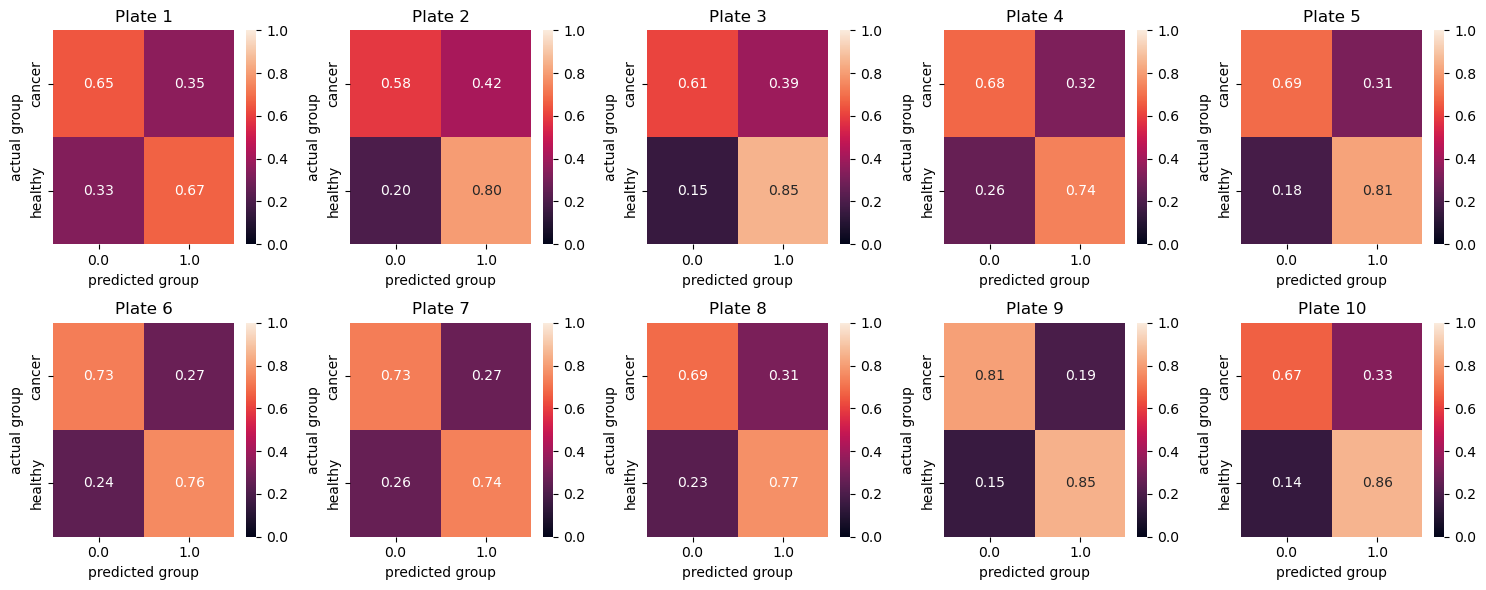

In [59]:
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for ax, plate in zip(axs.flatten(), use_plates):
    mat = pat_df[pat_df['plate'] == plate].groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
    mat = mat.div(mat.sum(axis=1), axis=0)
    sns.heatmap(mat, annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
    ax.set_ylabel('actual group')
    ax.set_xlabel('predicted group')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

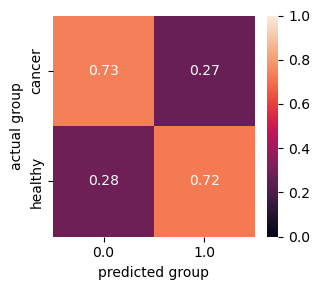

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(3.3, 3))
mat = pat_df.groupby(
        ['group', 'pred'])['counts'].sum().reset_index().pivot(index='group', columns='pred', values='counts')
mat = mat.div(mat.sum(axis=1), axis=0)
sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, fmt="0.2f",)
ax.set_ylabel('actual group')
ax.set_xlabel('predicted group')
fig.tight_layout()

In [61]:
res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()

,plate,pat,group,pred
0,1,H01,healthy,0.56
1,1,H02,healthy,0.76
2,1,H03,healthy,0.72
3,1,H04,healthy,0.66
4,1,H05,healthy,0.65
...,...,...,...,...
197,16,P139,cancer,0.06
198,16,P151,cancer,0.12
199,16,P45,cancer,0.03
200,16,P61,cancer,0.15


In [62]:
pat_df = res_without_df.groupby(['plate', 'pat', 'group'])['pred'].mean().reset_index()
plate_df = pat_df.groupby(['plate', 'group'])['pred'].mean().reset_index()
plate_df.loc[plate_df['group'] != 'healthy', 'group'] = 'C'
plate_df.loc[plate_df['group'] == 'healthy', 'group'] = 'H'
plate_df['group'] = pd.Categorical(values=plate_df['group'], categories=['H', 'C'])
plate_df['H'] = plate_df['pred']
plate_df['C'] = 1 - plate_df['H']
plate_df

,plate,group,pred,H,C
0,1,C,0.354286,0.354286,0.645714
1,1,H,0.670000,0.670000,0.330000
2,2,C,0.417778,0.417778,0.582222
3,2,H,0.800000,0.800000,0.200000
4,3,C,0.390000,0.390000,0.610000
5,3,H,0.852500,0.852500,0.147500
6,4,C,0.317778,0.317778,0.682222
7,4,H,0.737500,0.737500,0.262500
8,5,C,0.311250,0.311250,0.688750
9,5,H,0.815000,0.815000,0.185000


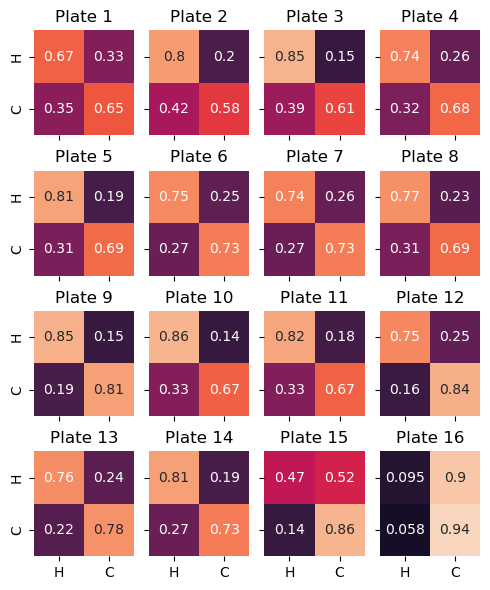

In [63]:
fig, axs = plt.subplots(4, 4, figsize=(5, 6), sharex=True, sharey=True)
for ax, plate in zip(axs.flatten(), use_plates):
    mat = plate_df[plate_df['plate'] == plate].set_index('group').loc[['H', 'C'], ['H', 'C']]
    sns.heatmap(mat.div(mat.sum(axis=1), axis=0), annot=mat, ax=ax, vmin=0, vmax=1, cbar=False)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(f'Plate {plate}')
fig.tight_layout()

In [64]:
print('done')

done
